In [80]:
import datetime
from pytz import timezone

import time
import numpy as np
import copy
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt

LAMBDA_PEN = 1000
L_BOUND = -10
U_BOUND = 10
N_POINTS = 512

NUM_EPOCHS = 5000

M_POINTS = 5
ALPHA = 2

SELECTION_RATE = 0.01

DISCRETE_POINTS = np.linspace(L_BOUND, U_BOUND, N_POINTS)

In [ ]:
DISCRETE_POINTS[1]-DISCRETE_POINTS[0]

0.039138943248532954

In [ ]:
2*U_BOUND/(N_POINTS-1)

0.03913894324853229

In [2]:
# PLOT DATA
def plot_figure(x_val, y_val, x_test=None, predicted=None, log_scale=False):
    plt.clf()
    plt.figure(figsize=(8, 6), dpi=80)
    if log_scale==True:
        plt.yscale('log')
    plt.plot(x_val, y_val, '--', label='True data', alpha=0.5)
    if predicted != None:
        plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.5)
    plt.legend(loc='best')
    plt.show()

In [3]:
def epsilon_Loss(v_x, model_u, upper_bound, discrete_points):
    """
    GOAL: Epsilon function evaluated at u using discretized estimation
    minimizing Epsilon(u) = 
    
    ARGS: 
    n_points (int): number of discretized points on the interval [-L, L]
    e.g.: -(L)|---|---|---|---|(L) interval has n_points = 5

    v_x (torch.Tensor): function instance
    model_u (torch.Tensor): model output
    """
    total = 0
    h = (2*upper_bound)/(len(discrete_points)-1)
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_xi = model_u(x_i)

        u_prime_x = model_u.u_prime(x_i)
        
        v_xi = v_x.forward(i)
        if v_xi < 0:
            raise ValueError('Potential Function value is < 0')
        t = torch.abs(torch.square(u_prime_x)) + v_xi*torch.square(u_xi)

        total += t
    return h*total

def epsilon_Loss_penalty(v_x, model_u, lambda_pen,
                         upper_bound, discrete_points):
    """
    
    """
    eps_sum = 0
    pen = 0

    h = (2*upper_bound)/(len(discrete_points)-1)
#     print("h = "+ str(h))
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)

        u_prime = model_u.u_prime(x_i)
        
        v_xi = v_x.forward(i)
        if v_xi < 0:
            raise ValueError('Potential Function value is < 0')
        u_xi = model_u(x_i)
        u_xi_square = torch.square(u_xi)

        t = torch.abs(torch.square(u_prime)) + v_xi*u_xi_square
        eps_sum += t
        
        pen+= u_xi_square
        
    epsilon_fn = h*eps_sum
    
    penalty = lambda_pen * torch.square(h*pen-1)
#     print("epsilon_fn value = " + str(epsilon_fn))
#     print("penalty value = " + str(penalty))
    return (epsilon_fn, epsilon_fn + penalty)

In [ ]:
a = epsilon_Loss(p_fn, model_32, U_BOUND, DISCRETE_POINTS[0:90])
print(a)
a2, b2, c2 = epsilon_Loss_penalty(p_fn, model_32, LAMBDA_PEN, U_BOUND, DISCRETE_POINTS[0:90])
print(a2)

In [ ]:
DISCRETE_POINTS[0:90][0]

In [ ]:
# ITERATIVE
tensor_points = []
for i in DISCRETE_POINTS:
    x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
    tensor_points.append(x_i)
start1 = time.time()
epsilon_Loss_penalty(p_fn, model_32, LAMBDA_PEN,
                     U_BOUND, np.random.choice(DISCRETE_POINTS, size=32))

# for i in tensor_points:
#     u_prime = model_64.u_prime(x_i)

end1 = time.time()
time1 = end1-start1
print("Time " + str(time1))

h = 0.6451612903225806
Time 0.018925189971923828


In [ ]:
e_fn.const

In [24]:
# CREATING MODEL CLASS
class Nonlinear(nn.Module):
    def __init__(self, n):
        # One hidden layer with n nodes
        super(Nonlinear, self).__init__()
        self.hidden = nn.Linear(1, n)
        self.output = nn.Linear(n, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, use_tanh_fn = False):
        if use_tanh_fn == True:
            x = self.hidden(x)
            x = self.tanh(x)
            x = self.output(x)
        else:
            x = self.hidden(x)
            x = self.sigmoid(x)
            x = self.output(x)
        return x

    def normalize_model(self, discrete_points):
        """
        GOAL: Normalize the output weight layer
        model.output *= c
        where,
        scalar c = 1/denom
        """
        
        h = discrete_points[1] - discrete_points[0]
        s = 0
        for i in discrete_points:
            x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
            s += self(x_i)**2
        denom = math.sqrt(h) * torch.sqrt(s)
        c = 1/denom

        print("Before normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        
        self.output.weight.data.copy_(c.item() * self.output.weight.data)
        self.output.bias.data.copy_(c.item() * self.output.bias.data)

        print("After normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        print("c value = " + str(c))

        return 

    def u_prime(self, x_in):
        y = self(x_in)
        y_prime = torch.autograd.grad(y.sum(), x_in, create_graph=True)
        return y_prime[0]
    
    # TRANING MODEL
    def minibatch_train_with_penalty(self, 
                                   num_epochs, 
                                   v_x, 
                                   optimizer, 
                                   lambda_pen,
                                   discrete_points,
                                   batch_size=32):
        # For plotting loss value over epochs:
        x_epochs = []
        y_loss = []
        y_loss_pen = []
        
        m = len(discrete_points)
        num_batches = int(m/batch_size)
#         print("Number of batches " + str(num_batches))

        for epoch in range(num_epochs):
            perm = torch.randperm(m)
            avg_loss_pen = 0
            avg_loss = 0

#                 start1 = time.time()
            for i in range(0, m, batch_size):
#                 print("i = " + str(i))
                optimizer.zero_grad()

                indices = perm[i: i+batch_size]

                loss_values = epsilon_Loss_penalty(v_x, self, lambda_pen,
                                                U_BOUND, 
                                                discrete_points[indices])

                loss = loss_values[0]
                loss_pen = loss_values[1]

                avg_loss_pen += loss_pen.item()
                avg_loss += loss.item()

                loss_pen.backward()
                optimizer.step()

            avg_loss_pen = avg_loss_pen/num_batches
            avg_loss = avg_loss/num_batches

            y_loss_pen.append(avg_loss_pen)
            y_loss.append(avg_loss)
            x_epochs.append(epoch)

            if epoch % 100 == 0 or epoch < 30:
                print('epoch {}, loss with penalty {}'.format(epoch, avg_loss_pen))

#                 if epoch == 0:
#                     end1 = time.time()
#                     time1 = end1-start1
#                     print("One epoch takes " + str(time1))

        print('Please normalize after training')
        return (x_epochs, y_loss_pen, y_loss)
    
    def batch_train_with_penalty(self, 
                             num_epochs, 
                             v_x, 
                             optimizer, 
                             lambda_pen, 
                             discrete_points):
        # For plotting loss value over epochs:
        x_epochs = []
        y_loss = []
        y_loss_pen = []


        for epoch in range(num_epochs):
            optimizer.zero_grad()
            loss_values = epsilon_Loss_penalty(v_x, self, lambda_pen,
                                        U_BOUND, discrete_points)

            loss = loss_values[0]
            loss_pen = loss_values[1]

            y_loss_pen.append(loss_pen.detach().numpy().item())
            y_loss.append(loss.detach().numpy().item())
            x_epochs.append(epoch)

            if epoch % 100 == 0 or epoch < 30:
                print('epoch {}, loss with penalty {}'.format(epoch, loss_pen.item()))
            loss_pen.backward()
            optimizer.step()

        print('Please normalize after training')
        return (x_epochs, y_loss_pen, y_loss)

In [ ]:
# For potential function
ti_list = np.random.normal(loc=0, scale=1.0, size= M_POINTS)
ci_list = [(U_BOUND/(i * math.pi))**ALPHA for i in range(1, M_POINTS+1)]


def potential_func_iterative(x, t_list, c_list, M_points=M_POINTS, L_endpoint=U_BOUND, c_0=50):
    f_value = 0
    summation = 0
    #Iterative method:

    for i in range(1, M_points+1):
        cos_val = np.cos((i * math.pi * x)/L_endpoint)
        summation += t_list[i-1] * c_list[i-1] * cos_val

    f_value += summation
    f_value += c_0

    return f_value


def potential_func_linalg(x, M_points=20, L_endpoint=U_BOUND, alpha=3, c_0=100):    
    # Linear Algebra method:
    t_i = np.random.normal(0, 1, size=N_points)
    
    iter1 = ((math.pi/(i*L_endpoint))**alpha for i in range(1, M_points+1))
    c_i = np.fromiter(iter1, float)
    a = np.multiply(t_i, c_i)

    iter2 = (i for i in range(1, M_points+1))
    v = np.fromiter(iter2, float)
    s = (L_endpoint*x/math.pi)*v
    cos_s = np.cos(s)
    
    res_vector = np.multiply(a, cos_s)
    return np.sum(res_vector) + c_0

In [25]:
class X_Square:
    def __init__(self, const):
        self.const = const
        
    def forward(self, x):
        return x**2 + self.const + 13*math.sin(x)
    
class Potential_Function:
    def __init__(self, c_0=0,
                 M_points=M_POINTS,
                 L_endpoint=U_BOUND, 
                 alpha=ALPHA, 
                 rescale=1):
        self.M_points = M_points
        self.L_endpoint = L_endpoint
        self.alpha = alpha
        self.c_0 = c_0
        self.rescale = 1
        
        self.ti_list = np.random.normal(loc=0, scale=1.0, size= self.M_points)
        self.ci_list = [(self.L_endpoint/(i * math.pi))**self.alpha 
                        for i in range(1, self.M_points+1)]
        
    def forward(self, x):
        f_value = 0
        summation = 0
        
        #Iterative method:

        for i in range(1, self.M_points+1):
            cos_val = np.cos((i * math.pi * x)/self.L_endpoint)
            summation += self.ti_list[i-1] * self.ci_list[i-1] * cos_val

        f_value += summation
        f_value += self.c_0
        return self.rescale * f_value
    
    def set_c0_value(self, val):
        self.c_0 = val
        return
    
    def set_rescale_factor(self, val):
        self.rescale = val
        return 
    
    def plot_function(self, discrete_points):
        y_values = [self.forward(i) for i in discrete_points]
        plt.plot(discrete_points, y_values)
    
    def update_potential_fn(self, discrete_points):
        # (1) Check lowest value to set appropriate c_0 value:
        y_values = [self.forward(i) for i in discrete_points]
        min_val = min(y_values)
        print("Original min val = " + str(min_val))
        # plt.plot(DISCRETE_POINTS, y_values)

        # (1) Set c_0 value s.t. every value in y_values is > 0: 
        if min_val < 0:
            c_0 = math.ceil(abs(min_val))
            self.set_c0_value(c_0)
            new_y = [self.forward(i) for i in discrete_points]
            print("Min val with c_0 updated = " + str(min(new_y)))
        # plt.plot(DISCRETE_POINTS, new_y)

        # (2) Rescale potential function s.t. every value lies between 0 and 5:
        max_v = max(new_y)
#         min_v = min(new_y)
#         print(max_v, min_v)
#         max_min = max_v-min_v

#         rescaled_y = [(i-min_v)/(max_min) for i in new_y]
#         plt.plot(DISCRETE_POINTS, rescaled_y)

#         c = 5/max_v
#         self.set_rescale_factor(c)
        return

In [26]:
def model_on_interval(nn_model, discrete_points):
    x_vals = [torch.tensor([i], requires_grad=True, dtype=torch.float) for i in discrete_points]

    model_output = []
    for i in x_vals:
        model_output.append(nn_model(i).detach().numpy().item())
    return model_output

In [ ]:
t_f = Potential_Function(c_0=50)
start = time.time()
r1 = [potential_func_iterative(i, t_list=ti_list, c_list=ci_list) for i in DISCRETE_POINTS]
end = time.time()
time1 = end-start
# print(r1)
print(time1)

start = time.time()
r2 = [t_f.forward(i) for i in DISCRETE_POINTS]
end = time.time()
time2 = end-start
# print(r2)
print(time2)

0.018739938735961914
0.017675161361694336


In [ ]:
start = time.time()
res1 = 10**2
end = time.time()
time1 = end-start
print(time1)

start = time.time()
res2 = potential_func_iterative(10)
end = time.time()
time2 = end-start
print(time2)

In [85]:
learningRate = 0.01

#INIT MODEL
batch_model = Nonlinear(20)
model_32 = Nonlinear(20)
model_64 = Nonlinear(20)
model_128 = Nonlinear(20)
if torch.cuda.is_available():
    model_32.cuda()
    model_64.cuda()

# INIT OPTIMIZER CLASS
# SGD:
# sgd_optimizer = torch.optim.SGD(model_32.parameters(), 
#                                 lr=learningRate, 
#                                 momentum=0.9)

# Adam:
adam_optimizer = torch.optim.Adam(batch_model.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

adam_optimizer_2 = torch.optim.Adam(model_64.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

adam_optimizer_3 = torch.optim.Adam(model_128.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)


In [84]:
del adam_optimizer
del adam_optimizer_2
del adam_optimizer_3

del model_32
del model_64
del model_128
del batch_model

In [18]:
p_fn.c_0 

4

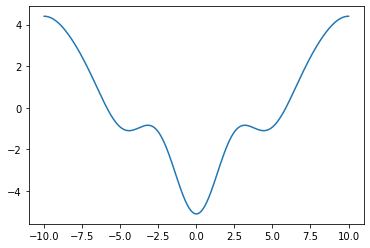

In [71]:
# Init. potential function instance
p_fn = Potential_Function()
p_fn.plot_function(DISCRETE_POINTS)

Original min val = -5.103986121893788
Min val with c_0 updated = 0.8960138781062117


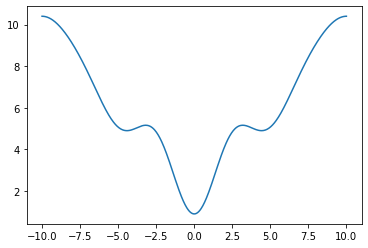

In [72]:
p_fn.update_potential_fn(DISCRETE_POINTS)
p_fn.plot_function(DISCRETE_POINTS)

In [ ]:
# Check lowest value to set appropriate c_0 value:
y_values = [p_fn.forward(i) for i in DISCRETE_POINTS]
min_val = min(y_values)
print("Original min val = " + str(min_val))
# plt.plot(DISCRETE_POINTS, y_values)

# Set c_0 value s.t. every value in y_values is > 0: 
c_0 = math.ceil(abs(min_val))
p_fn.set_c0_value(c_0)
new_y = [p_fn.forward(i) for i in DISCRETE_POINTS]

# plt.plot(DISCRETE_POINTS, new_y)

# Rescale potential function s.t. every value lies between 0 and 5:
max_v = max(new_y)
min_v = min(new_y)
print(max_v, min_v)
max_min = max_v-min_v

rescaled_y = [(i-min_v)/(max_min) for i in new_y]
plt.plot(DISCRETE_POINTS, rescaled_y)

In [86]:
batch_res = None

In [87]:
model_res_32 = None
model_res_64 = None
model_res_128 = None

In [88]:
### TRAIN MODEL HERE ###
def run_batch_training(nn_model, v_x, optimizer):
    
    now = datetime.datetime.now(tz=timezone('US/Eastern'))
    print("Start time is " + str(now))
    start = time.time()
    
    model_res = nn_model.batch_train_with_penalty(NUM_EPOCHS, 
                                                v_x, 
                                                optimizer, 
                                                LAMBDA_PEN, 
                                                DISCRETE_POINTS)
    end = time.time()
    time1 = end-start
    print("Using potential function defined as class takes " + str(time1))
    return model_res

def run_minibatch_training(nn_model, v_x, optimizer, b_size):
    now = datetime.datetime.now(tz=timezone('US/Eastern'))
    print(("Start time for batch_size = {a} is " + str(now)).format(a=b_size))
    start = time.time()
    
    model_res = nn_model.minibatch_train_with_penalty(NUM_EPOCHS, 
                                                      v_x, 
                                                      optimizer, 
                                                      LAMBDA_PEN, 
                                                      DISCRETE_POINTS,
                                                      batch_size=b_size)
    
    end = time.time()
    time1 = end-start
    print("Using potential function defined as class takes " + str(time1))
    return model_res

In [ ]:
test_model = Nonlinear(20)
adam_opt = torch.optim.Adam(test_model.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)
test_res = run_minibatch_training(test_model, e_fn, adam_opt, b_size=64)

Start time for batch_size = 64 is 2022-07-31 23:33:55.488200-04:00
epoch 0, loss with penalty 177.89723777770996
epoch 1, loss with penalty 94.34998774528503
epoch 2, loss with penalty 81.68863534927368
epoch 3, loss with penalty 70.31339979171753
epoch 4, loss with penalty 97.55239152908325
epoch 5, loss with penalty 95.44247102737427
epoch 6, loss with penalty 84.83988237380981
epoch 7, loss with penalty 69.59263396263123
epoch 8, loss with penalty 89.90981960296631
epoch 9, loss with penalty 72.49066400527954
epoch 10, loss with penalty 72.36901521682739
epoch 11, loss with penalty 79.76749110221863
epoch 12, loss with penalty 74.57911205291748
epoch 13, loss with penalty 83.59079837799072
epoch 14, loss with penalty 83.74671411514282
epoch 15, loss with penalty 66.45458769798279
epoch 16, loss with penalty 122.03101181983948
epoch 17, loss with penalty 101.30830359458923
epoch 18, loss with penalty 109.7941575050354
epoch 19, loss with penalty 85.37106227874756
epoch 20, loss with 

In [ ]:
test_model.normalize_model(DISCRETE_POINTS)

Before normalization: 
tensor([[-0.5032, -0.1080, -0.3893,  0.2031,  0.3566,  0.0120,  0.2418,  0.0127,
          0.5411,  0.0084,  0.0101,  0.0208,  0.0082, -0.2132,  0.0298,  0.0201,
          0.0101,  0.1381,  0.0095,  0.1273]])
tensor([-0.0353])
After normalization: 
tensor([[-0.5032, -0.1080, -0.3893,  0.2031,  0.3566,  0.0120,  0.2418,  0.0127,
          0.5411,  0.0084,  0.0101,  0.0208,  0.0082, -0.2132,  0.0298,  0.0201,
          0.0101,  0.1381,  0.0095,  0.1273]])
tensor([-0.0353])
c value = tensor([1.], grad_fn=<MulBackward0>)


In [89]:
batch_res = run_batch_training(batch_model, p_fn, adam_optimizer)

Start time is 2022-08-01 16:11:24.167524-04:00
epoch 0, loss with penalty 169.05592346191406
epoch 1, loss with penalty 58.68549346923828
epoch 2, loss with penalty 70.75250244140625
epoch 3, loss with penalty 7.629458904266357
epoch 4, loss with penalty 32.67408752441406
epoch 5, loss with penalty 44.203514099121094
epoch 6, loss with penalty 18.86356544494629
epoch 7, loss with penalty 8.776008605957031
epoch 8, loss with penalty 33.23569869995117
epoch 9, loss with penalty 25.867778778076172
epoch 10, loss with penalty 7.489900588989258
epoch 11, loss with penalty 13.845556259155273
epoch 12, loss with penalty 24.477745056152344
epoch 13, loss with penalty 19.785430908203125
epoch 14, loss with penalty 8.658624649047852
epoch 15, loss with penalty 9.161776542663574
epoch 16, loss with penalty 17.83131217956543
epoch 17, loss with penalty 15.436503410339355
epoch 18, loss with penalty 7.727183818817139
epoch 19, loss with penalty 8.616869926452637
epoch 20, loss with penalty 13.63216

In [95]:
batch_model.normalize_model(DISCRETE_POINTS)

Before normalization: 
tensor([[-0.1568,  0.0527,  0.0432, -0.3124, -0.1290, -0.2499,  0.0620,  0.3747,
          0.2662,  0.1734, -0.1432,  0.0887,  0.1620, -0.2815, -0.0190, -0.4765,
          0.3117,  0.1218, -0.1346, -0.2023]])
tensor([0.2113])
After normalization: 
tensor([[-0.1566,  0.0526,  0.0432, -0.3120, -0.1288, -0.2495,  0.0619,  0.3742,
          0.2658,  0.1732, -0.1430,  0.0886,  0.1618, -0.2812, -0.0190, -0.4759,
          0.3113,  0.1216, -0.1344, -0.2020]])
tensor([0.2110])
c value = tensor([0.9987], grad_fn=<MulBackward0>)


<Figure size 432x288 with 0 Axes>

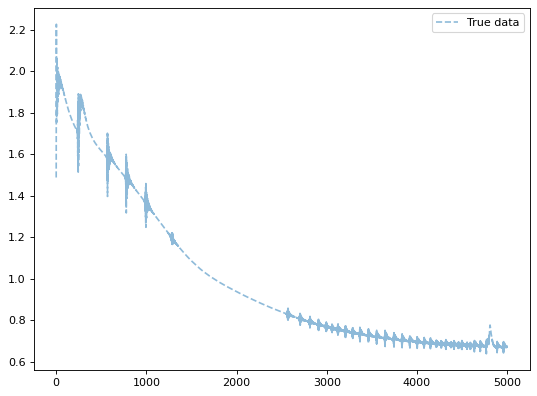

In [90]:
plot_figure(batch_res[0], np.log(batch_res[2]))

<Figure size 432x288 with 0 Axes>

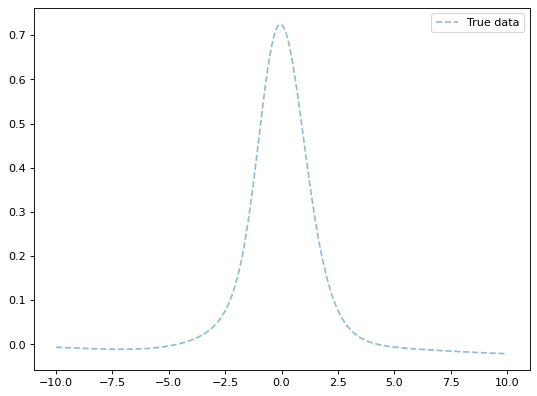

In [91]:
x_values = np.linspace(L_BOUND, U_BOUND, N_POINTS)
x_vals = [torch.tensor([i], requires_grad=True, dtype=torch.float) for i in np.linspace(L_BOUND, U_BOUND, N_POINTS)]

model_output = model_on_interval(batch_model, DISCRETE_POINTS)

plot_figure(x_values, model_output)
# plot_figure(x_values, model_output)

## The Finite Difference Method ##

In [40]:
def fd_method_2(lower_bound, upper_bound, N_points, given_fn):
    discrete_points = np.linspace(lower_bound, upper_bound, N_points)
    h = discrete_points[1]-discrete_points[0]
    c = np.sqrt(1/h)
    H = np.zeros((N_points-2,N_points-2))
    # Question: Why H has dimension (N-2) x (N-2)?
    V = np.zeros((N_points-2,N_points-2))
    
    for i in range (N_points-2):
        for j in range (N_points-2):
            if i == j:
                H[i][j] = -2
            elif abs(i-j) == 1:
                H[i][j] = 1
                
    for i in range (N_points-2):
        for j in range (N_points-2):
            if i == j:
                V[i][j] = given_fn.forward(discrete_points[i])
                
    A = -H/(h**2) + V
    
    eig_val, eig_vec = np.linalg.eig(A)
    sorted_id_eig_val = np.argsort(eig_val)
    # Get the indices that would sort eig_val
    z = sorted_id_eig_val[0:1] # Bc. eig_val first 4 value is in ascending order, 
    # eig_val[z] will return sorted first [T] value of eigenvalues.
    energies = eig_val[z]/eig_val[z][0]

    ground_state = c * eig_vec[:,z[0]]

    return (eig_val[z], ground_state)

In [41]:
def finite_diff_method(lower_bound, upper_bound, N_points, given_fn):
    discrete_points = np.linspace(lower_bound, upper_bound, N_points)
    h = discrete_points[1]-discrete_points[0]
    c = np.sqrt(1/h)

    H = np.zeros((N_points,N_points))
    # Question: Why H has dimension (N-2) x (N-2)?
    V = np.zeros((N_points,N_points))

    for i in range (N_points):
        for j in range (N_points):
            if i == j:
                H[i][j] = -2
            elif abs(i-j) == 1:
                H[i][j] = 1
    for i in range (N_points):
        for j in range (N_points):
            if i == j:
                V[i][j] = given_fn.forward(discrete_points[i])

    A = -H/(h**2) + V
    
    eig_val, eig_vec = np.linalg.eig(A)
    sorted_id_eig_val = np.argsort(eig_val)
    # Get the indices that would sort eig_val
    z = sorted_id_eig_val[0:1] # Bc. eig_val first 4 value is in ascending order, 
    # eig_val[z] will return sorted first [T] value of eigenvalues.
    energies = eig_val[z]/eig_val[z][0]

    ground_state = c * eig_vec[:,z[0]]

    return (eig_val[z], ground_state)

In [43]:
def plot_finite_diff_sol(eig_val, ground_state, discrete_points, nn_model):
    plt.figure(figsize=(12,10))
    for i in range(len(eig_val)):
        y = []
        y = np.append(y, (-1) * ground_state)

        plt.plot(discrete_points,y,lw=3, label="{} ".format(i))
        plt.xlabel('x', size=14)
        plt.ylabel('$\psi$(x)',size=14)
    model_output = model_on_interval(nn_model, DISCRETE_POINTS)
    plt.plot(discrete_points, model_output)
    plt.legend()
    plt.title('normalized wavefunctions for a harmonic oscillator using finite difference method',size=14)
    plt.show()
    return

In [92]:
fd_res = finite_diff_method(L_BOUND, U_BOUND, N_POINTS, p_fn)
fd_res2 = fd_method_2(L_BOUND, U_BOUND, N_POINTS, p_fn)
print(fd_res[0])
print(fd_res2[0])

[1.93522426]
[1.93522426]


In [96]:
loss_val = epsilon_Loss_penalty(p_fn, batch_model, LAMBDA_PEN, U_BOUND, DISCRETE_POINTS)[0]
print("The FD method eigenvalue: " + str(fd_res[0][0]))
print("The NN method loss value: " + str(loss_val.item()))

The FD method eigenvalue: 1.9352242609244739
The NN method loss value: 1.957866907119751


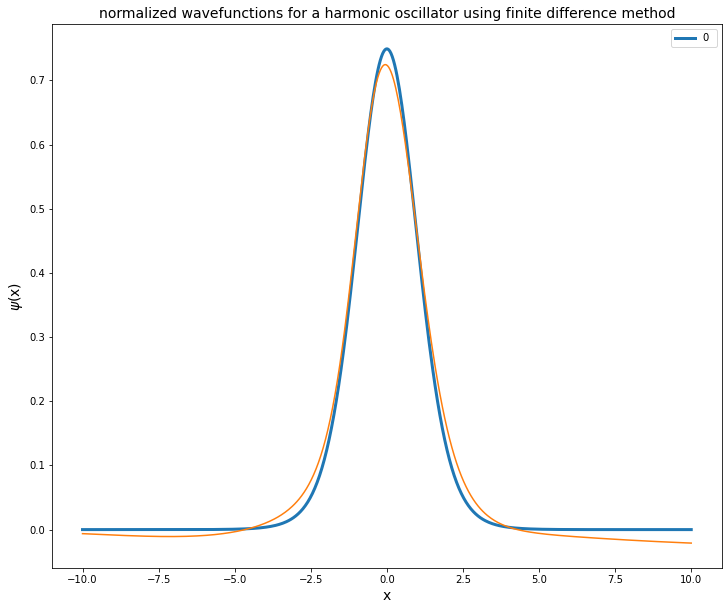

In [94]:
plot_finite_diff_sol(fd_res[0], fd_res[1], DISCRETE_POINTS, batch_model)